#Second Practical work

Authors:
Mireia Alba Kesti Izquierdo (100406960)
and
Aleksandra Jamróz (100491363)


This second practical work skeleton is divided in the following 4 parts:

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data
4.   GPU load





##Module load section
### PyCUDA modules
First, we will install the pycuda module in the Google Colaboratory environment, to be able to combine Python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

We will install the automatic initialization module (pycuda.autoinit) to automatically perform all the steps necessary to get CUDA ready for submission of compute kernels. These steps, namely initialization, context creation, and cleanup, could also be carried out manually, but we believe it is more convenient to do it automatically with this module.

We will also use the gpuarray module to be able to associate a numpy array with an array on the device. This way, we will be able to handle transfers, and express array operations on the GPU with the syntax of numpy arrays.



### Other modules
We will also load the numpy and matplotlib modules.

To transfer data onto the device we chose numpy because it is an efficient way of having objects for multi-dimenstional arrays. We say it is more efficient than other alternatives because it uses less memory to store data & is faster. 

We use the matplotlib library to create the visualizations.  

In [1]:
# First of all, check that runtime type is set to GPU
# Go to Runtime --> Change runtime type 

In [2]:
# If using Google Collab - install the pycuda module
# Else, comment the next line
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import the necessary Python modules numpy, pycuda and time module

# Import numpy
import  numpy  as  np 

# Import and initilize CUDA - load modules to initialize communication to GPU
import  pycuda.autoinit #Contains all functions that are automatically imported when using pycuda
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv #Python wrapper for CUDA
import  pycuda.gpuarray as  gpuarray

# Import module to return the size of an object in bytes
from sys import getsizeof

# Import Python time module to measure code's efficiency
import time

In [4]:
# Import modules necessary for image handling & display

#%pylab inline
%matplotlib inline

from PIL import Image # PIL is the Python Imaging Library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

##Mount Google Drive and grant access
We use Google's API to allow access to our Google Drive.

For security and privacy reasons, this permission is temporary and will be requested every time the notebook is restarted. 

The Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive". The images have to be copied to a folder in the "My Drive" folder in your Google Drive.

In [5]:
# Mounted our Google Drive to this colab notebook
from os.path import join
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
MYDRIVE = "/content/drive/My Drive/Images_P2_MC"

In [7]:
# List the files available in the selected folder
# Check that all our images are in the folder
!ls /content/drive/My\ Drive/Images_P2_MC

chess.jpg  cloudsonjupi.jpg  digits.jpg  fence.jpg  hand-x-ray.jpg


In [8]:
# Define an image variable for one of our prespecified images in our G Drive folder
# Define a variable "image". Constructed by joining the MYDRIVE variable + image path
IMAGE = join(MYDRIVE,'fence.jpg')
print("Image to load: {0}".format(IMAGE))

Image to load: /content/drive/My Drive/Images_P2_MC/fence.jpg


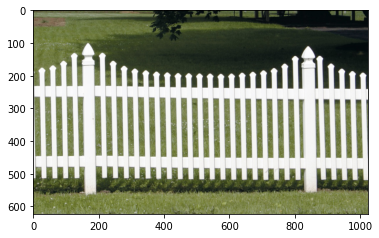

In [9]:
# Load image in a numpy array & display the image
image = np.array(Image.open(IMAGE))
plt.figure()
plt.imshow(image)

#FILTER KERNEL

In [10]:
# Defined image_filter GPU kernel

kernel  =  """
__global__ void image_filter( float * image,          //Source GPU array floating point 32 bits
		                          float * filter_mask,    //Filter Mask GPU array 2D floating point 32 bits
                              float * filtered_image, //Target GPU array 2D floating point 32 bits
                              int NumRowsImg,         //Image Numrows
                              int NumColsImg,         //Int32 Image Numcolumns
                              int NumRowsFilter,      //Int32 Image NumRows filter mask
                              int NumColsFilter       //Int32 Image NumCols filter mask
                              ) 
{ 

// Calculate how many rows & columns we have to take
int additional_rows_number = (NumRowsFilter-1)/2; 
int additional_cols_number = (NumColsFilter-1)/2; 

// Define the shared memory for the sub-matrix of an image layer
__shared__ float ds_layer[%(BLOCK_SIZE)s * %(BLOCK_SIZE)s];

// Define the thread indexes 
const uint tx = threadIdx.x;
const uint ty = threadIdx.y;

// Define column & row indexes 
int col = blockIdx.x * %(TILE_SIZE)s + tx ;
int row = blockIdx.y * %(TILE_SIZE)s + ty ; 

int row_i = row - additional_rows_number; 
int col_i = col - additional_cols_number;


// Fill the tile memory
if (row_i < NumRowsImg && row_i >= 0){
  if (col_i < NumColsImg && col_i >= 0)
    ds_layer[ty * blockDim.x + tx] = image[col_i + row_i * NumColsImg];
  else if ((col_i >= NumColsImg && col_i < NumColsImg+additional_cols_number))
    ds_layer[ty * blockDim.x + tx] = image[NumColsImg - 1 + row_i * NumColsImg];
  else if (col_i >= - additional_cols_number && col_i < 0)
    ds_layer[ty * blockDim.x + tx] = image[row_i * NumColsImg];
}

else if (row_i >= NumRowsImg && row_i < NumRowsImg + additional_rows_number){
  if (col_i < NumColsImg && col_i >= 0)
      ds_layer[ty * blockDim.x + tx] = image[col_i + (NumRowsImg-1) * NumColsImg];
    else if ((col_i >= NumColsImg && col_i < NumColsImg+additional_cols_number))
      ds_layer[ty * blockDim.x + tx] = image[NumColsImg - 1 + (NumRowsImg-1) * NumColsImg];
    else if (col_i >= - additional_cols_number && col_i < 0)
      ds_layer[ty * blockDim.x + tx] = image[(NumRowsImg-1) * NumColsImg];
}

else if (row_i >= - additional_rows_number && row_i < 0){
  if (col_i < NumColsImg && col_i >= 0)
      ds_layer[ty * blockDim.x + tx] = image[col_i + 0 * NumColsImg];
    else if ((col_i >= NumColsImg && col_i < NumColsImg+additional_cols_number))
      ds_layer[ty * blockDim.x + tx] = image[NumColsImg - 1 + 0 * NumColsImg];
    else if (col_i >= - additional_cols_number && col_i < 0)
      ds_layer[ty * blockDim.x + tx] = image[0 * NumColsImg];
}

else
  ds_layer[ty * blockDim.x + tx] = 0;                        

// Sync the threads to make sure the image is loaded
__syncthreads();


// Filter computation

float temp = 0.0f; 

if (ty < %(TILE_SIZE)s && tx < %(TILE_SIZE)s)
{ 
  temp = 0; 
  for (int i = 0; i < NumRowsFilter ; i++)
  {
    for (int j = 0; j < NumColsFilter ; j++)
    { 
      temp += filter_mask[j + i * NumColsFilter] * ds_layer[(ty + i)* blockDim.x + (tx + j)];
    }
  }
  if (row < NumRowsImg && col < NumColsImg)
  {
    filtered_image[col + row * NumColsImg] = temp; 
  }    
}  
}

"""

In [11]:
# Get the image shape & select the two first items (rows & columns)
image_shape = image.shape[0:2]
image_shape

(623, 1024)

In [12]:
# Define the tile, block, and gride sizes

# Define the tile size 
TILE_SIZE = 12

# Define the block size 
# We define a block execution size of 16x16x1 threads. This will allocate 256 threads per block < 1024 (the most common maximum threads/block)
# We take this value to get up to 256 parallel threads per block 
BLOCK_SIZE = 16 
block_size = (BLOCK_SIZE, BLOCK_SIZE, 1)

# Define the grid size
grid_size = (int(np.ceil(image_shape[1]/TILE_SIZE)),int(np.ceil(image_shape[0]/TILE_SIZE)))

In [13]:
# Get the kernel code from the template by specifying the tile & block size constants

kernel = kernel % { 'TILE_SIZE': TILE_SIZE, 'BLOCK_SIZE': BLOCK_SIZE }


In [14]:
kernel = SourceModule(kernel)

In [15]:
# Retrieve the necessary kernel by calling the get_function() method
image_filter = kernel.get_function ('image_filter')

In [16]:
# Allocate the target image memory
result_image = np.zeros(image.shape,dtype=np.uint8)

In [17]:
# Define the # of layers in the image & print it
# If the image is gray-scale: 1 layer
# Else (image has colours): calculate depth
if len(image.shape) == 2:
    depth = 1
else:
    depth = image.shape[2]
    
print(depth)

3


### Filter masks definition
First, we must define the filters that we are going to apply to our image to filter it. We will define these filters as numpy arrays.

In [18]:
# Define the 5 sample filter masks as numpy arrays 

# Filter 1 - impulse response filter
filter1 = np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])

# Filter 2 - edge filter, first order in x axis
filter2 = np.array([[0.5, 0 , -0.5]])

# Filter 3 - edge filter, first order in y axis
filter3 = np.array([[0.5],[0],[-0.5]])

# Filter 4 - edge filter, second order, bi-directional
filter4 = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

# Filter 5 - blur gausian filter
filter5 = np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

In [19]:
# Now that the available filters are defined, we can choose which one we wish to apply

# Select the desired filter mask
filter_mask = filter3.astype(np.float32)

#return a GPUArray that is an exact copy of the numpy array data, i.e. transfer the array to the GPU
filter_mask_gpu = gpuarray.to_gpu(filter_mask)

# Print the filter in the GPU to check if it corresponds with our filter definition
print(filter_mask_gpu)

[[ 0.5]
 [ 0. ]
 [-0.5]]


##Preparation of the execution environment 

In [20]:
# Allocate the temporal filtered memory layer (where the filtered image will be stored)
# Create an empty GPU array
filtered_image_layer_gpu = gpuarray.zeros(image_shape,np.float32)
filtered_image_layer_gpu.shape

(623, 1024)

In [21]:
# Main block definition
# Go through the layers, copying the selected layer to temporal image_layer, upload the layer to the GPU and invoke the image_filter kernel
# Also, compute the time it has taken to run

start_t = time.time()

# Filter application 
for layer in range(depth):
  image_layer = np.zeros(image_shape,dtype=np.float32) # Allocate the temporal image layer
  image_layer = (image[:,:,layer]).astype(np.float32)    # Copy from the orignal image the selected layer into the temporal memory
  image_layer_gpu = gpuarray.to_gpu(image_layer)         # Upload the image layer to the GPU
  filtered_image_layer_gpu.fill(0.0)                   # Fill the target memory in the GPU with 0s
  image_filter(                                        # Invoke the kernel
          image_layer_gpu,
          filter_mask_gpu,
          filtered_image_layer_gpu,
          np.int32(image_shape[0]),
          np.int32(image_shape[1]),
          np.int32(filter_mask.shape[0]),
          np.int32(filter_mask.shape[1]),
          block = block_size,
          grid = grid_size
        )

# Filtered image
  filtered_image_layer = filtered_image_layer_gpu.get() # Download the filtered image from the GPU
  result_image[:,:,layer] = filtered_image_layer.astype(np.uint8) # Copy the filtered image to the final image store, 
                                                                  # casting the data type from double to uint8
end_t = time.time()

#Result visualization


In [22]:
# Calculate & display execution time 
print("Execution time is: {0} seconds.".format(end_t - start_t))

Execution time is: 0.020220279693603516 seconds.


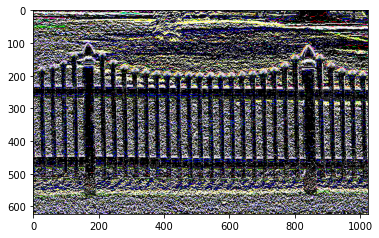

In [23]:
# Plot the filtered image
plt.figure()
plt.imshow(result_image)

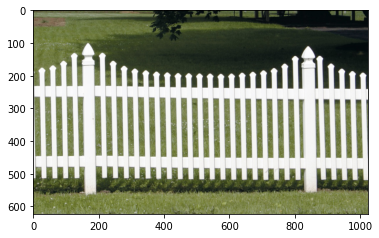

In [24]:
# Plot the unfiltered image
plt.figure()
plt.imshow(image)

## Future development 
In the next piece of code, we compare the runtime of numpy and cupy to fulfill the same task. The objective of this, is to check if this program could further be optimized. 

In [25]:
# Python program to compare speed of cupy vs numpy
import cupy as cp #a numpy compatible library for GPU. More efficient than numpy
  
#NumPy & CPU runtime
time1 = time.time()
three_d_array_cpu = np.ones((1000,1000,1000))
time2 = time.time()
print("Time consumed using numpy: ", time2-time1)
  
# CuPy and GPU Runtime
time_1 = time.time()
three_d_array_gpu = cp.ones((1000,1000,1000))
time_2 = time.time()
print("\nTime consumed using cupy: ", time_2 - time_1)

Time consumed using numpy:  1.8610844612121582

Time consumed using cupy:  0.9461832046508789


## Conclusion

Matrix multiplication is a good example of a process that can be performed more efficiently by using parallel computing.

By tiling, we can partition the data into subsets (tiles) so that each tile can fit into the shared memory. We do this because when using CUDA device memories there is a tradeoff: large but slow global memory, and small but fast shared memory. By partitioning the data, we can reduce memory traffic, i.e. we can reduce the global memory accesses by taking advantage of the GPU's shared memory. When we partition the data into subsets that fit into the shared memory, we can really exploit the advantaged of memory-level parallelism.

This can be clearly seen in the improvement in runtime (efficiency), when comparing the different methods, as we demonstrated in the different sessions. Thus, for this project we decided to directly implement this method to apply the filter to the image. 
As we can observe, this filtering was very efficient, the runtime was negligible. In the first project, in comparison, it took much longer to filter the image. Hence, we have a good comparison of how the same task (filtering an image), can be done much more efficiently if we do not depend on the physical limitations of our computer hardware, and instead, harness the power of the GPU. 

### Considerations

It is crucial to be aware of the data sizes, block sizes, grid sizes, and the element types in each of these arrays. If they are not correctly set, it will not compile correctly, and/or we will not be making the most efficient use of our resources. 
This is because GPU devices assign each processor a thread which executes the program (kernel) over the data which has been previously uploaded to the GPU's main memory. 

As we can see in the test that is run after the filtering of the images in which we compare the runtime (efficiency) of numpy versus cupy, cupy proves to be an additional efficiency increase. This is due to the fact that cupy is a numpy compatible library specifically designed for GPU programming. Hence, to further improve this program, cupy should be used instead. 